In [31]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble 
from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
import math
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-09-25 23:18:44,251: Credentials are already in use. The existing account in the session will be replaced.


In [32]:
def decimalToBinary(n):
    return "{0:b}".format(int(n))
    

In [33]:
input_list = [1, 5, 4, 2]
n = int(math.ceil(math.log(max(input_list), 2)))
print(n)
binary_list = []
for x in input_list:
    binary_list.append(decimalToBinary(x))
print(binary_list)
qc = QuantumCircuit(n)
matrix_4qubits = np.asmatrix(np.eye(16), dtype=int)
matrix_4qubits[5, 5] = -1
matrix_4qubits[10, 10] = -1
matrix_5qubits = np.asmatrix(np.eye(32), dtype=int)
matrix_5qubits[21, 21] = -1
matrix_5qubits[10, 10] = -1
matrix_3qubits = [[1,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,-1,0,0,0,0,0],[0,0,0,1,0,0,0,0],[0,0,0,0,1,0,0,0],[0,0,0,0,0,-1,0,0],[0,0,0,0,0,0,1,0],[0,0,0,0,0,0,0,1]]
matrix_2qubit = np.asmatrix(np.eye(4), dtype=int)
matrix_2qubits[1, 1] = -1
matrix_2qubits[2, 2] = -1
if n == 5:
    oracle_z = UnitaryGate(matrix_5qubits, "U$_\omega$")
if n == 4:
    oracle_z = UnitaryGate(matrix_4qubits, "U$_\omega$")
if n == 3:
    oracle_z = UnitaryGate(matrix_3qubits, "U$_\omega$")
if n == 2:
    oracle_z = UnitaryGate(matrix_2qubits, "U$_\omega$")
#qc.x(0)
#qc.cz(0, 2)
#qc.cz(0,1)
#qc.x(0)
qc.unitary(oracle_z,list(range(n)))
oracle_ex3 = qc.to_gate()
#oracle_ex3.name = "U$_\omega$"

3
['1', '101', '100', '10']


In [34]:
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

In [35]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [36]:
#n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, list(range(n)))
grover_circuit.append(oracle_ex3, list(range(n)))
grover_circuit.append(diffuser(n), list(range(n)))
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌───────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0              ├┤0       ├─░─┤M├──────
        ├───┤│               ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 circuit-1010 ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│               ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2              ├┤2       ├─░──╫──╫─┤M├
        └───┘└───────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/════════════════════════════════════╩══╩══╩═
                                            0  1  2

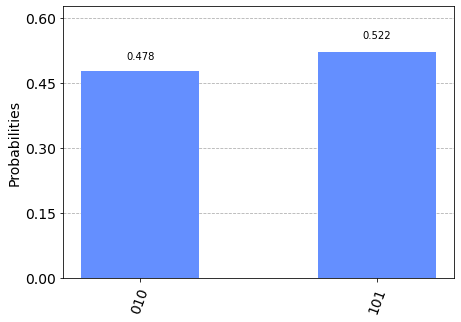

In [37]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)